# 1. Loading the data and basic preprocessing

##### Data: Financial indicators of Taiwan companies (source: Taiwan Economic Journal 1999–2009)

##### Task: Bankruptcy prediction

https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction

In [2]:
import numpy as np
import pandas as pd
from collections import Counter
from itertools import permutations

import matplotlib
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split

import seaborn as sn

import os
import re
import math

from tools.utils import str_to_readable_title, filter_dataset, pd_to_cubes

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [4]:
matplotlib.rcParams.update({'font.size': 16})

## 1.1. Read data

In [4]:
df = pd.read_csv("data/data.csv")

In [5]:
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.000000e+00,0.458143,7.250725e-04,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,2.559237e-02,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.000000e+00,0.461867,6.470647e-04,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9

Column names

In [6]:
list(df)[:10]

['Bankrupt?',
 ' ROA(C) before interest and depreciation before interest',
 ' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' Operating Gross Margin',
 ' Realized Sales Gross Margin',
 ' Operating Profit Rate',
 ' Pre-tax net Interest Rate',
 ' After-tax net Interest Rate',
 ' Non-industry income and expenditure/revenue']

##### Basic normalization of column names:
* remove blank chars at the begining/end of string
* remove possible double spaces
* lowercase

In [7]:
normalize_names = lambda x: re.sub("[\?\s]+", " ", x).strip().lower()

In [8]:
df.rename(columns=normalize_names, inplace=True)

In [9]:
col_names = list(df)

In [10]:
col_names[:10]

['bankrupt',
 'roa(c) before interest and depreciation before interest',
 'roa(a) before interest and % after tax',
 'roa(b) before interest and depreciation after tax',
 'operating gross margin',
 'realized sales gross margin',
 'operating profit rate',
 'pre-tax net interest rate',
 'after-tax net interest rate',
 'non-industry income and expenditure/revenue']

##### Adjust data types

In [11]:
# df.dtypes

In [12]:
df.__sizeof__()

5237120

In [13]:
df[df.dtypes[df.dtypes == np.float64].index] = df[df.dtypes[df.dtypes == np.float64].index].astype(np.float32)
df[df.dtypes[df.dtypes == np.int64].index] = df[df.dtypes[df.dtypes == np.int64].index].astype(np.uint8)

In [14]:
df.__sizeof__()

2557253

In [7]:
def add_value_label(x_list,y_list):
    for i in range(len(x_list)):
        plt.text(i, y_list[i], '{0:.2%}'.format(y_list[i]), size=16)

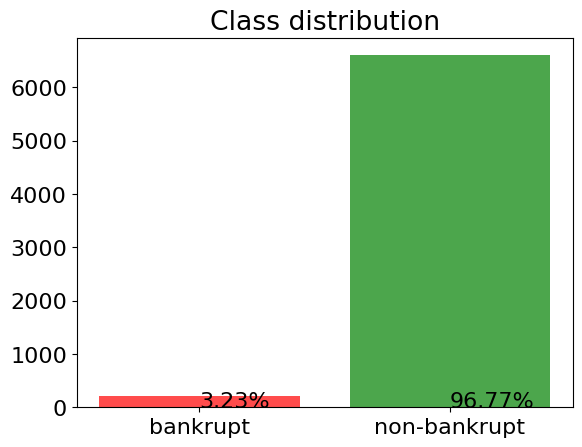

In [16]:
matplotlib.rcParams.update({'font.size': 16})

num_yes = len(df[df['bankrupt'] == 1])
num_no = len(df[df['bankrupt'] == 0])

plt.bar(['bankrupt', 'non-bankrupt'], [num_yes, num_no], color=['red', 'green'], alpha=0.7)
plt.title("Class distribution")
add_value_label(['bankrupt', 'non-bankrupt'], 
                [round(num_yes / (num_no + num_yes), 4), round(num_no / (num_no + num_yes), 4)])

## 1.2. Data cleaning and preprocessing

Before feeding ML algorithms the data should be normalized. Values from different features have to be roghly from the same range to ensure that features with higher values are not effecting algorithms in higher extent.

But we know that most of the columns (if not all of them) represent financial idnicators, that are supposed to be in range (0, 1), thereby don't need to be normalized.

So let's check it out. We make histograms for each column to see if all of them actualy have values in range (0, 1).

Shorten version

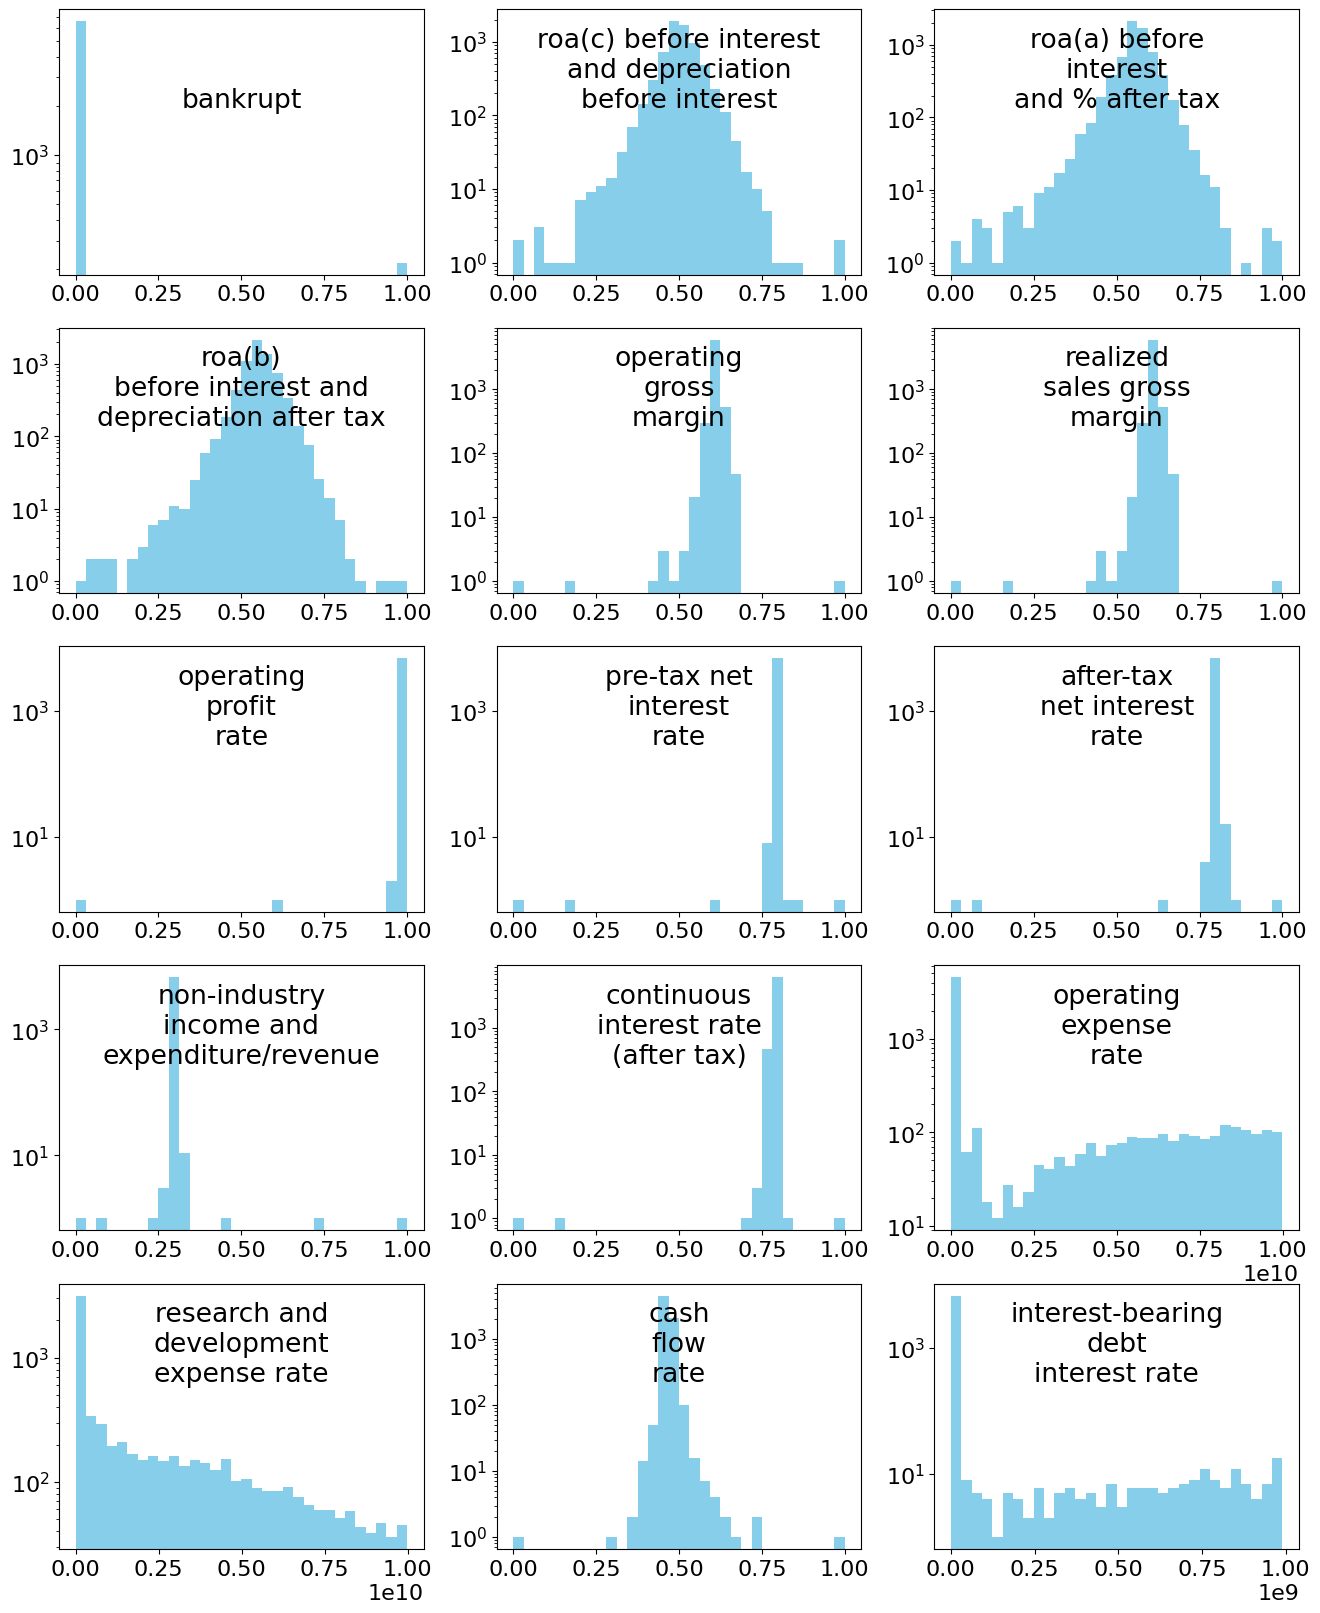

In [17]:
matplotlib.rcParams.update({'font.size': 16})

n_cols = len(df.columns) // 6
c, r = 3, math.floor(n_cols / 3)
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(16, 20))

for i in range(n_cols-1):
    title = str_to_readable_title(df.columns[i], max_lines=3)
    row_id, col_id = i // 3, i % 3
    ax[row_id, col_id].hist(df.iloc[:, i], log=True, bins=32, color = "skyblue")
    ax[row_id, col_id].set_title(title, x=0.5, y=0.6)
    

plt.show()
fig.savefig(os.path.join('images', 'feature_histograms.png'))

Full column set

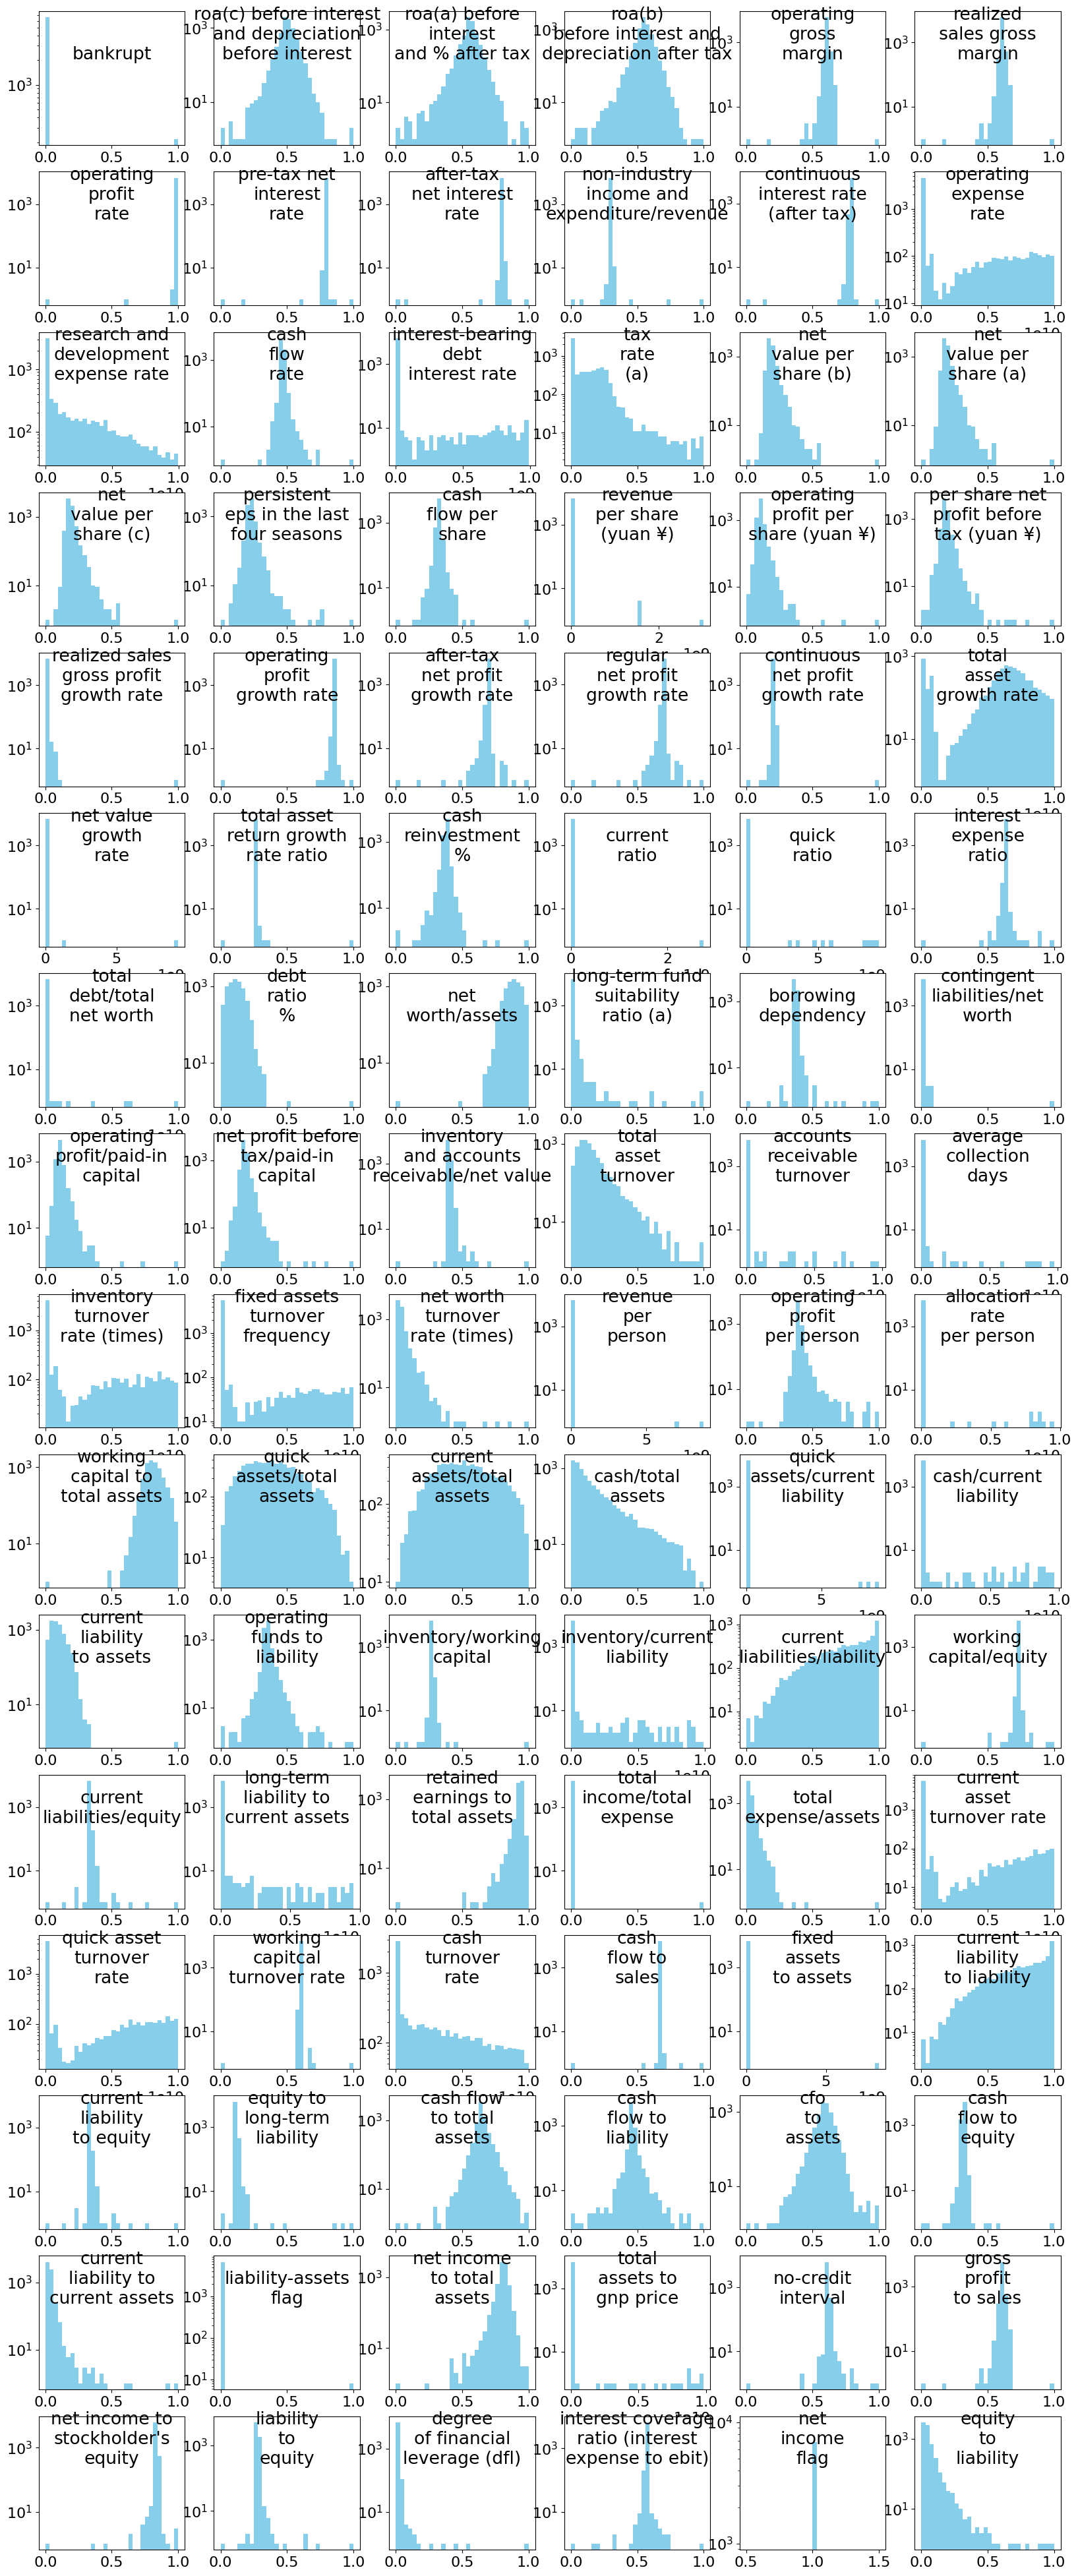

In [18]:
matplotlib.rcParams.update({'font.size': 16})

n_cols = len(df.columns)
c, r = 6, math.floor(len(df.columns) / 6)
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(20, 50))

for i in range(n_cols):
    title = str_to_readable_title(df.columns[i], max_lines=3)
    row_id, col_id = i // 6, i % 6
    ax[row_id, col_id].hist(df.iloc[:, i], log=True, bins=32, color = "skyblue")
    ax[row_id, col_id].set_title(title, x=0.5, y=0.6)
    

plt.show()
fig.savefig(os.path.join('images', 'feature_histograms.png'))

We can see that some columns (`Operating Expense Rate`, `Research and development expense rate`, ...) have significant number (let's say >100) of values above 1 and up to 10e10. There are also columns (`Revenue per Share`, `Current Ratio`, ...) with insignificant (let's say <100) number of values from a mentioned range. The reason for occasionally high values is that they probably represent just a one of the elements of a given financial indicator. 

This fact makes such observations/features irrelevant for ML algorithms as the same feature gives different type of knowledge for different observations. To give an example, Operating Expense Rate (OER) = Operating Expenses / Net Sales. Significant part of observations have OER in range (0, 1) actually representing ratios, - the second part has OER > 1 probably representing just an Operating Expenses.

This brings us to the "data cleaning" step as we need to remove either rows or columns containing irrelevant values. But which dataset's dimension (rows or columns) do we have to chose to clean along? Well, for a performance of ML models both the number of observations and the number of features are important in terms of amount of information they give. Thereby while removing, we want to keep as many of them as possible. 

My proposition for handling this issue is to:
* remove columns with significant number of irrelevant values and
* remove rows where at least one of the feature has insignificant number of irrelevant values.

But how do we determine what is that threshold, which tells if column has significant or insignificant number of irrelevant values? Well, this is a parameter, for which we need to figure out an optimal value. We can do that by testing different thresholds and finding the one that keeps the most data from original dataset (this can be simply measured as `NUMBER_OF_ROWS_LEFT * NUMBER_OF_COLUMNS_LEFT`). Another important thing to keep in mind is that our data is highly imbalanced (~3.3% bankrupts, 96.7% non-bankrupts), and we can't remove a lot of bankrupt instances. 

---

In [20]:
df[(df > 1).any(axis=1)].shape[0] / df.shape[0]

0.9914943540108521

In [21]:
(df > 1).any(axis=0).mean()

0.25

In [22]:
matplotlib.rcParams.update({'font.size': 16})

##### Remove flag (binary) columns from filtering (excl. `bankrupt` column)

In [23]:
df_X = df.copy()
df_X = df_X.drop(columns=list(df.columns[df.isin([1,0]).all()]))
df_X['bankrupt'] = df['bankrupt']

In [24]:
df_X.head()

,roa(c) before interest and depreciation before interest,roa(a) before interest and % after tax,roa(b) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,pre-tax net interest rate,after-tax net interest rate,non-industry income and expenditure/revenue,continuous interest rate (after tax),operating expense rate,research and development expense rate,cash flow rate,interest-bearing debt interest rate,tax rate (a),net value per share (b),net value per share (a),net value per share (c),persistent eps in the last four seasons,cash flow per share,revenue per share (yuan ¥),operating profit per share (yuan ¥),per share net profit before tax (yuan ¥),realized sales gross profit growth rate,operating profit growth rate,after-tax net profit growth rate,regular net profit growth rate,continuous net profit growth rate,total asset growth rate,net value growth rate,total asset return growth rate ratio,cash reinvestment %,current ratio,quick ratio,interest expense ratio,total debt/total net worth,debt ratio %,net worth/assets,long-term fund suitability ratio (a),borrowing dependency,contingent liabilities/net worth,operating profit/paid-in capital,net profit before tax/paid-in capital,inventory and accounts receivable/net value,total asset turnover,accounts receivable turnover,average collection days,inventory turnover rate (times),fixed assets turnover frequency,net worth turnover rate (times),revenue per person,operating profit per person,allocation rate per person,working capital to total assets,quick assets/total assets,current assets/total assets,cash/total assets,quick assets/current liability,cash/current liability,current liability to assets,operating funds to liability,inventory/working capital,inventory/current liability,current liabilities/liability,working capital/equity,current liabilities/equity,long-term liability to current assets,retained earnings to total assets,total income/total expense,total expense/assets,current asset turnover rate,quick asset turnover rate,working capitcal turnover rate,cash turnover rate,cash flow to sales,fixed assets to assets,current liability to liability,current liability to equity,equity to long-term liability,cash flow to total assets,cash flow to liability,cfo to assets,cash flow to equity,current liability to current assets,net income to total assets,total assets to gnp price,no-credit interval,gross profit to sales,net income to stockholder's equity,liability to equity,degree of financial leverage (dfl),interest coverage ratio (interest expense to ebit),equity to liability,bankrupt
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.006889,0.391590,0.012335,0.751111,0.127236,0.1824

In [25]:
arr_t = np.arange(df_X.shape[0], step=5)  # possible thresholds
arr_t[0] = 1
df_tresholds = pd.DataFrame(data={'thresholds': arr_t,
                                 'data_keep_ratio': np.zeros(arr_t.shape[0]),
                                 'bankruptcy_ratio': np.zeros(arr_t.shape[0])
                                 }
                           )

ints = df_tresholds.dtypes[df_tresholds.dtypes == int].index
floats = df_tresholds.dtypes[df_tresholds.dtypes == float].index
df_tresholds[ints] = df_tresholds[ints].astype(np.uint16)
df_tresholds[floats] = df_tresholds[floats].astype(np.float32)
df_tresholds

,thresholds,data_keep_ratio,bankruptcy_ratio
0,1,0.0,0.0
1,5,0.0,0.0
2,10,0.0,0.0
3,15,0.0,0.0
4,20,0.0,0.0
...,...,...,...
1359,6795,0.0,0.0
1360,6800,0.0,0.0
1361,6805,0.0,0.0
1362,6810,0.0,0.0


In [26]:
def filter_dataset_and_calculate_info_drop(row):
    data_keep_ratio, bankrupt_ratio = filter_dataset(df_X, label_col='bankrupt', t=row[0], return_df=False)
    return pd.Series([row[0], data_keep_ratio, bankrupt_ratio],
                    index=['thresholds', 'data_keep_ratio', 'bankruptcy_ratio']
                    ).astype(np.float16)

In [27]:
df_tresholds = df_tresholds.apply(filter_dataset_and_calculate_info_drop, axis=1)
df_tresholds

,thresholds,data_keep_ratio,bankruptcy_ratio
0,1.0,0.744629,0.032257
1,5.0,0.796875,0.031860
2,10.0,0.826172,0.031647
3,15.0,0.835449,0.031708
4,20.0,0.844238,0.031799
...,...,...,...
1359,6796.0,0.008507,0.000000
1360,6800.0,0.008507,0.000000
1361,6804.0,0.008507,0.000000
1362,6808.0,0.008507,0.000000


In [28]:
df_tresholds[df_tresholds.data_keep_ratio == df_tresholds.data_keep_ratio.max()]

,thresholds,data_keep_ratio,bankruptcy_ratio
10,50.0,0.866211,0.029602
11,55.0,0.866211,0.029602
12,60.0,0.866211,0.029602
13,65.0,0.866211,0.029602
14,70.0,0.866211,0.029602
15,75.0,0.866211,0.029602
16,80.0,0.866211,0.029602
17,85.0,0.866211,0.029602
18,90.0,0.866211,0.029602
19,95.0,0.866211,0.029602


In [29]:
opt_thresholds = df_tresholds.thresholds[df_tresholds.data_keep_ratio == df_tresholds.data_keep_ratio.max()].values
opt_thresholds

array([50., 55., 60., 65., 70., 75., 80., 85., 90., 95.], dtype=float16)

Text(0, 0.5, 'Bankruptcy ratio')

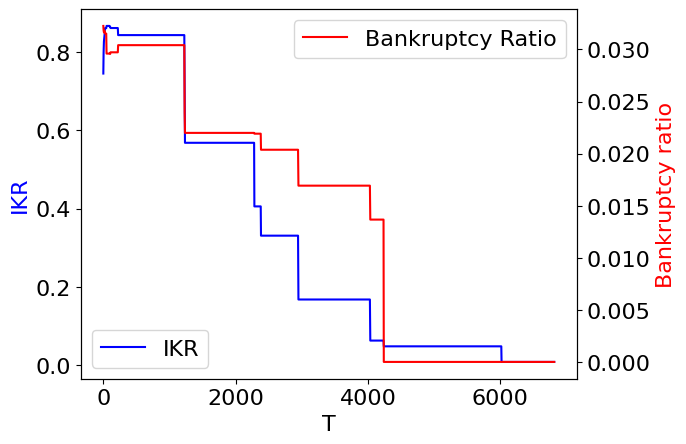

In [30]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1, = ax1.plot(df_tresholds.thresholds, df_tresholds.data_keep_ratio, color='blue', label='IKR')
ax1.legend(handles=[l1], loc ='lower left')
l2, = ax2.plot(df_tresholds.thresholds, df_tresholds.bankruptcy_ratio, color='red', label='Bankruptcy Ratio')
ax2.legend(handles=[l2], loc='upper right')

# plt.axvline(x=opt_thresh, color='green', linestyle='dashed')
# plt.legend(loc='upper left')
ax1.set_xlabel('T')
ax1.set_ylabel('IKR', color='blue')
ax2.set_ylabel('Bankruptcy ratio', color='red')
# ax2.set_ylim((2e-2, 4e-2))
# plt.title('Threshold and information lost')

##### Zoom in

In [31]:
rng = (0, 500)
df_tresholds_zoomed = df_tresholds[(df_tresholds.thresholds >= rng[0]) & (df_tresholds.thresholds <= rng[1])]

Text(0, 0.5, 'Bankruptcy ratio')

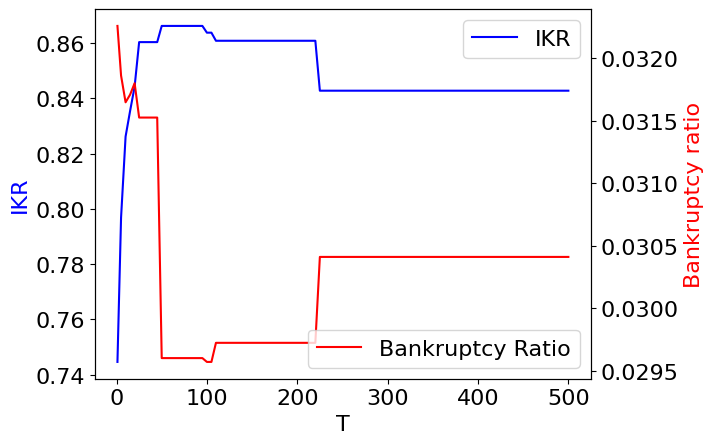

In [32]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1, = ax1.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.data_keep_ratio, color='blue', label='IKR')
ax1.legend(handles=[l1], loc ='upper right')
l2, = ax2.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.bankruptcy_ratio, color='red', label='Bankruptcy Ratio')
ax2.legend(handles=[l2], loc='lower right')

ax1.set_xlabel('T')
ax1.set_ylabel('IKR', color='blue')
ax2.set_ylabel('Bankruptcy ratio', color='red')

##### Add `information kept x bankruptcy ratio` coefficient

In [33]:
df_tresholds_zoomed.loc[:,'ik_br_coeff'] = df_tresholds_zoomed['data_keep_ratio'] * df_tresholds_zoomed['bankruptcy_ratio']

/tmp/ipykernel_6550/3586746089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tresholds_zoomed.loc[:,'ik_br_coeff'] = df_tresholds_zoomed['data_keep_ratio'] * df_tresholds_zoomed['bankruptcy_ratio']


Text(0, 0.5, 'Bankruptcy ratio')

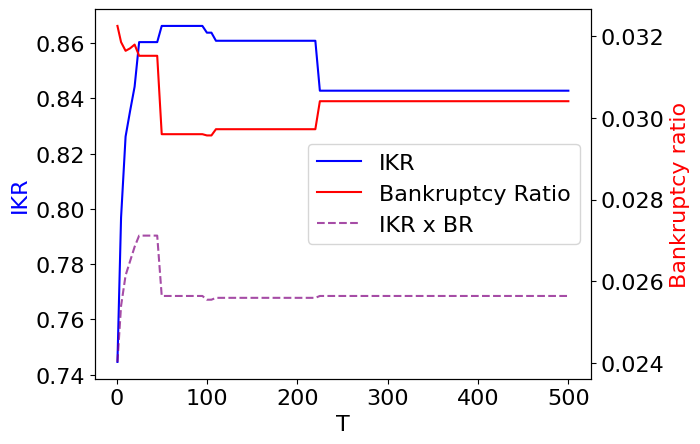

In [34]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1, = ax1.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.data_keep_ratio, color='blue', label='IKR')
l2, = ax2.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.bankruptcy_ratio, color='red', label='Bankruptcy Ratio')
l3, = ax2.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.ik_br_coeff, color='purple', linestyle='dashed', alpha=0.7, label='IKR x BR')
ax2.legend(handles=[l1, l2, l3], loc='center right')

ax1.set_xlabel('T')
ax1.set_ylabel('IKR', color='blue')
ax2.set_ylabel('Bankruptcy ratio', color='red')

In [35]:
df_tresholds_zoomed[df_tresholds_zoomed.ik_br_coeff == df_tresholds_zoomed.ik_br_coeff.max()]

,thresholds,data_keep_ratio,bankruptcy_ratio,ik_br_coeff
5,25.0,0.860352,0.031525,0.027115
6,30.0,0.860352,0.031525,0.027115
7,35.0,0.860352,0.031525,0.027115
8,40.0,0.860352,0.031525,0.027115
9,45.0,0.860352,0.031525,0.027115


In [36]:
opt_thresholds = df_tresholds_zoomed.thresholds[df_tresholds_zoomed.ik_br_coeff == df_tresholds_zoomed.ik_br_coeff.max()].values
opt_thresholds

array([25., 30., 35., 40., 45.], dtype=float16)

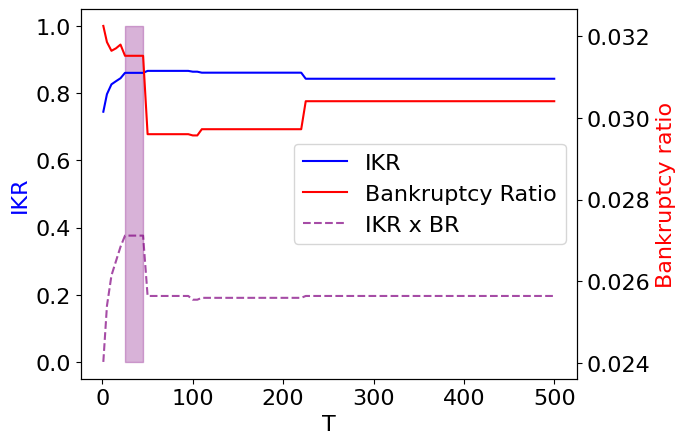

In [37]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1, = ax1.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.data_keep_ratio, color='blue', label='IKR')
l2, = ax2.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.bankruptcy_ratio, color='red', label='Bankruptcy Ratio')
l3, = ax2.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.ik_br_coeff, color='purple', linestyle='dashed', alpha=0.7, label='IKR x BR')
ax2.legend(handles=[l1, l2, l3], loc='center right')

ax1.set_xlabel('T')
ax1.set_ylabel('IKR', color='blue')
ax2.set_ylabel('Bankruptcy ratio', color='red')

ax1.fill_between(x=opt_thresholds, y1=0, y2=1, color='purple', alpha=0.3)

In [38]:
new_df = filter_dataset(df_X, label_col='bankrupt', t=opt_thresholds[0], return_df=True)

In [39]:
new_df

,roa(c) before interest and depreciation before interest,roa(a) before interest and % after tax,roa(b) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,pre-tax net interest rate,after-tax net interest rate,non-industry income and expenditure/revenue,continuous interest rate (after tax),cash flow rate,tax rate (a),net value per share (b),net value per share (a),net value per share (c),persistent eps in the last four seasons,cash flow per share,revenue per share (yuan ¥),operating profit per share (yuan ¥),per share net profit before tax (yuan ¥),realized sales gross profit growth rate,operating profit growth rate,after-tax net profit growth rate,regular net profit growth rate,continuous net profit growth rate,net value growth rate,total asset return growth rate ratio,cash reinvestment %,current ratio,quick ratio,interest expense ratio,total debt/total net worth,debt ratio %,net worth/assets,long-term fund suitability ratio (a),borrowing dependency,contingent liabilities/net worth,operating profit/paid-in capital,net profit before tax/paid-in capital,inventory and accounts receivable/net value,total asset turnover,accounts receivable turnover,average collection days,net worth turnover rate (times),revenue per person,operating profit per person,allocation rate per person,working capital to total assets,quick assets/total assets,current assets/total assets,cash/total assets,quick assets/current liability,current liability to assets,operating funds to liability,inventory/working capital,current liabilities/liability,working capital/equity,current liabilities/equity,retained earnings to total assets,total income/total expense,total expense/assets,working capitcal turnover rate,cash flow to sales,fixed assets to assets,current liability to liability,current liability to equity,equity to long-term liability,cash flow to total assets,cash flow to liability,cfo to assets,cash flow to equity,current liability to current assets,net income to total assets,total assets to gnp price,no-credit interval,gross profit to sales,net income to stockholder's equity,liability to equity,degree of financial leverage (dfl),interest coverage ratio (interest expense to ebit),equity to liability,bankrupt
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,0.458143,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,0.147308,0.334015,0.276920,0.676269,0.721275,0.339077,0.903225,0.002022,0.064856,0.593831,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,0.461867,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,0.025484,0.006889,0.391590,0.012335,0.751111,0.127236,0.182419,0.014948,0.004136,0.056963,0.341106,0.289642,0.308589,0.731975,0.329740,0.931065,0.002226,0.025516,0.593916,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794,1
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,0.458521,0.000000,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,0.000396,0.264184,0.368913

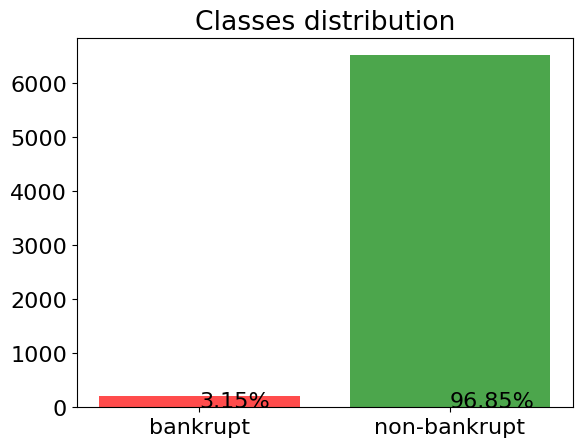

In [40]:
num_yes = len(new_df[new_df['bankrupt'] == 1])
num_no = len(new_df[new_df['bankrupt'] == 0])

plt.bar(['bankrupt', 'non-bankrupt'], [num_yes, num_no], color=['red', 'green'], alpha=0.7)
plt.title("Classes distribution")
add_value_label(['bankrupt', 'bon-bankrupt'], 
                [round(num_yes / (num_no + num_yes), 4), round(num_no / (num_no + num_yes), 4)])

### 1.4 Feature Correlations

We also suppose that some attributes are higly correlated, like `Pre-tax interest rate` and `After-tax interest rate`. The second feature doesn't bring any knew knowledge on a problem, so it's better to remove it for minimizing the chance of paying more attention at "Interest rates" area.

The execution would look like that:
1. Find correlated subsets of attributes (subset may consist of more that 2 elements as well)
2. Leave only one out of all correlated attributes for particular subset.

But first let's visualize the features correlations by using heatmaps.

### 1.4.1 Heatmaps

In [102]:
features = list(new_df.columns)
features.remove('bankrupt')

<Axes: >

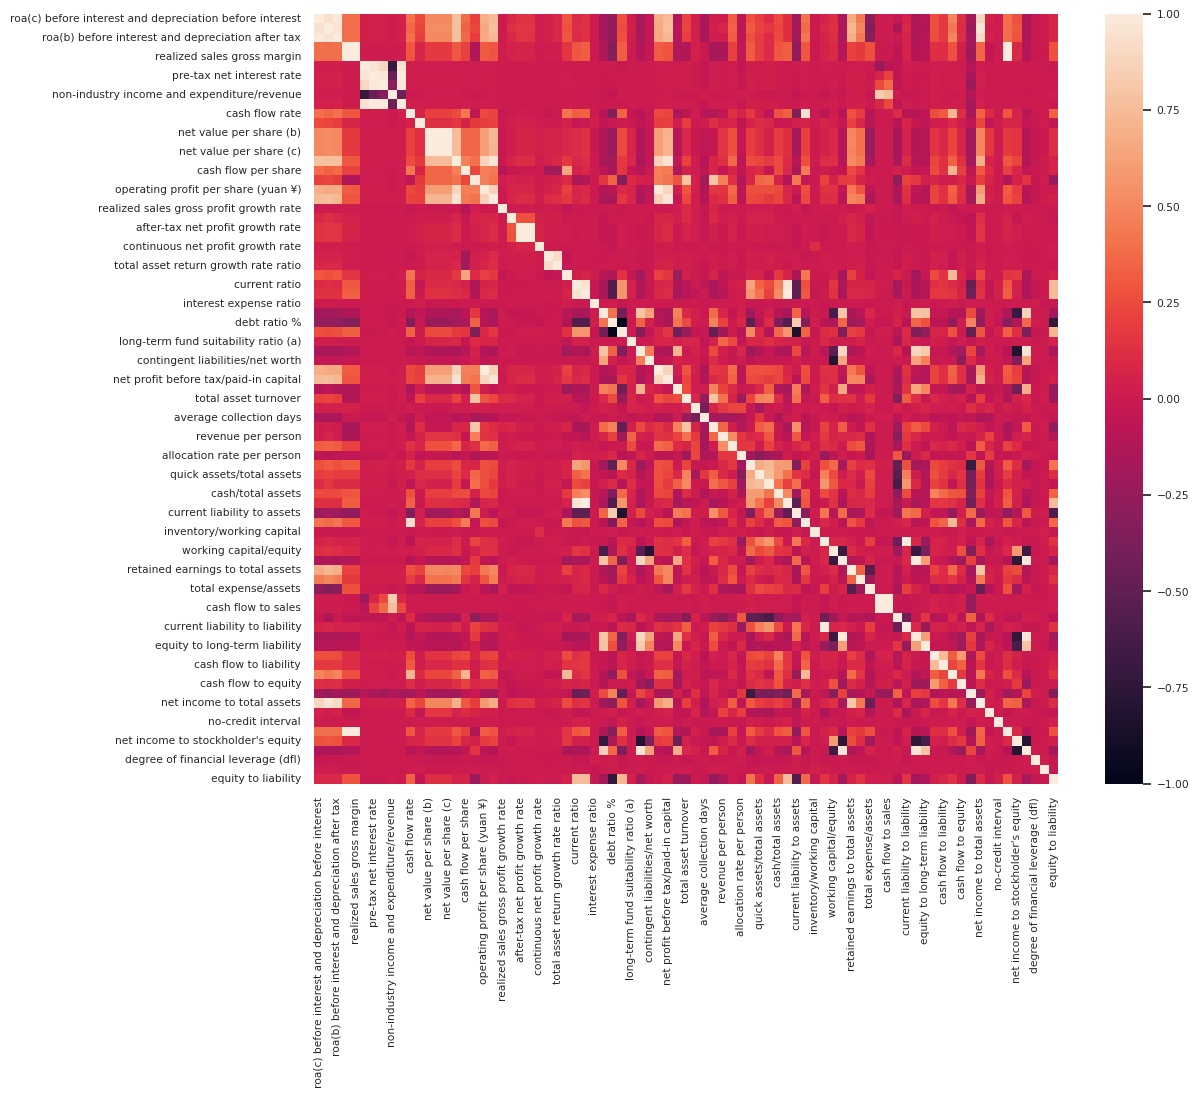

In [103]:
sn.set(font_scale=0.7)
df_X = new_df[features]
df_corr = df_X.corr()
f, axes = plt.subplots(1, figsize=(12,10))
sn.heatmap(df_corr)

A bit messy, isn't it?

Let's try to improve the readability by splitting the heatmap into smaller subcubes (10x10)

#### First 10 columns

<Axes: >

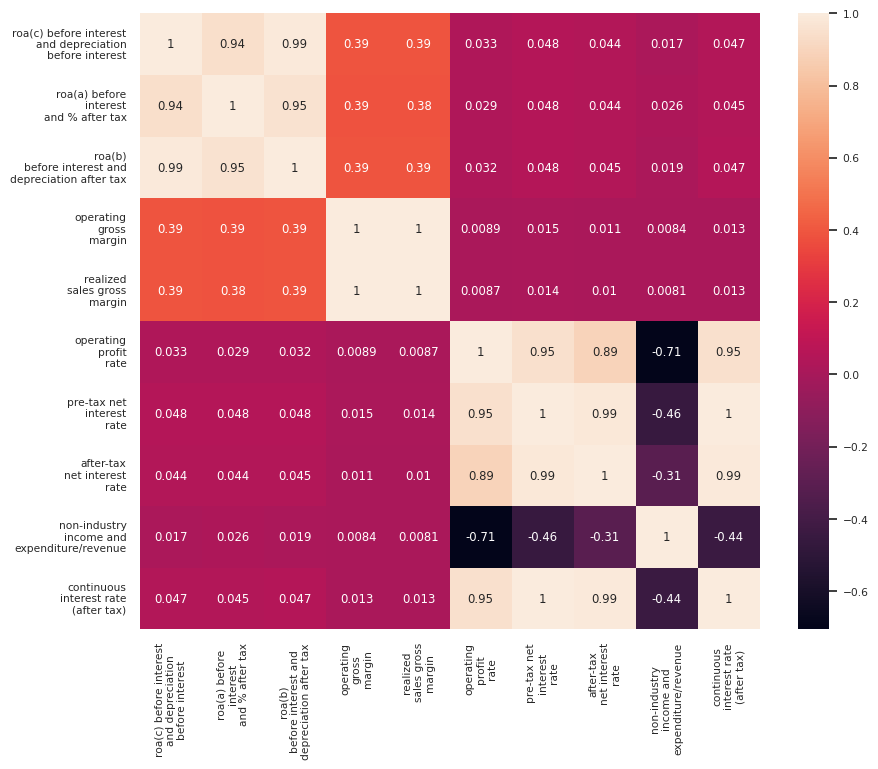

In [84]:
sn.set(font_scale=0.7)
df_X = new_df[features[:10]]
df_corr = df_X.corr()
df_corr.columns = list(map(lambda colname: str_to_readable_title(colname, max_lines=3), df_corr.columns))
df_corr.index = df_corr.columns
f, axes = plt.subplots(1, figsize=(10,8))
sn.heatmap(df_corr, annot=True)

#### Heatmap Subcubes 

In [74]:
df_corr.shape

(81, 81)

In [75]:
# split column names into several lines for more readability
df_corr.columns = list(map(lambda colname: str_to_readable_title(colname, max_lines=3), df_corr.columns))
df_corr.index = df_corr.columns
df_corr = df_corr.apply(np.round, decimals=2)

In [76]:
cube_len = 10
cubes_per_line = 2

In [77]:
cubes = pd_to_cubes(df_corr, cube_len=cube_len)
n_cubes = len(cubes)

In [ ]:
matplotlib.rcParams.update({'font.size': 24})

c, r = cubes_per_line, n_cubes // cubes_per_line + 1
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(80, 80))

for i, cube in enumerate(cubes):
    row_id, col_id = i // cubes_per_line, i % cubes_per_line
    sn.heatmap(cube, annot=True, ax=ax[row_id, col_id])

plt.show()

Now open corresponding .png file in images folder and zoom in.

In [46]:
# fig.savefig(os.path.join('images', 'correlation_heatmaps.png'))

---

### 1.4.2. Remove highly correlated features

First, let's define a threshold, that tells if two features are correlated to each other or not, as 0.9 

In [104]:
CORR_THRESHOLD = 0.75

##### Find correlated features

In [105]:
# all possible pairs of features
corr_pairs = list(permutations(df_corr.index, 2))

In [106]:
# left only correlated ones
corr_pairs = list(filter(lambda pair: abs(df_corr.loc[pair[0], pair[1]]) > CORR_THRESHOLD, corr_pairs))

In [107]:
# remove pair dublicates
corr_pairs = set(frozenset(tupl) for tupl in corr_pairs)
corr_pairs = [set(pair) for pair in corr_pairs]

In [108]:
corr_pairs

[{'persistent eps in the last four seasons',
  'roa(a) before interest and % after tax'},
 {'operating profit per share (yuan ¥)',
  'persistent eps in the last four seasons'},
 {'current liabilities/equity', 'total debt/total net worth'},
 {'net income to total assets', 'retained earnings to total assets'},
 {'net worth turnover rate (times)', 'revenue per share (yuan ¥)'},
 {'cash flow rate', 'operating funds to liability'},
 {'after-tax net interest rate', 'operating profit rate'},
 {'roa(a) before interest and % after tax',
  'roa(b) before interest and depreciation after tax'},
 {'roa(a) before interest and % after tax',
  'roa(c) before interest and depreciation before interest'},
 {'per share net profit before tax (yuan ¥)',
  'roa(a) before interest and % after tax'},
 {'current liability to equity', "net income to stockholder's equity"},
 {'roa(b) before interest and depreciation after tax',
  'roa(c) before interest and depreciation before interest'},
 {'net profit before tax

We see that some attributes are repeated in different pairs. That's why we need to merge these correlated pairs into correlated sets. 

One way to do that is to write a few nested loops, but it's not fun. Let's do it a bit trickier - with recursion. Though it doesn't mean we will avoid nested loops at all :)

In [109]:
def merge_corr_pair_sets(list_of_sets):
    length = len(list_of_sets)
    l_copy = list_of_sets.copy()
    
    for i in range(length):
        for j in range(i+1, length):
            if list_of_sets[i].intersection(list_of_sets[j]):
                l_copy[i].update(l_copy[j])
                l_copy.remove(l_copy[j])
                return merge_corr_pair_sets(l_copy)
    return l_copy

In [110]:
corr_sets = merge_corr_pair_sets(corr_pairs)

In [111]:
corr_sets

[{'net income to total assets',
  'net profit before tax/paid-in capital',
  'net value per share (a)',
  'net value per share (b)',
  'net value per share (c)',
  'operating profit per share (yuan ¥)',
  'operating profit/paid-in capital',
  'per share net profit before tax (yuan ¥)',
  'persistent eps in the last four seasons',
  'retained earnings to total assets',
  'roa(a) before interest and % after tax',
  'roa(b) before interest and depreciation after tax',
  'roa(c) before interest and depreciation before interest'},
 {'borrowing dependency',
  'current liabilities/equity',
  'current liability to equity',
  'equity to long-term liability',
  'liability to equity',
  "net income to stockholder's equity",
  'total debt/total net worth'},
 {'net worth turnover rate (times)',
  'revenue per share (yuan ¥)',
  'total asset turnover'},
 {'cash flow rate', 'operating funds to liability'},
 {'after-tax net interest rate',
  'continuous interest rate (after tax)',
  'operating profit 

Results are just what we could expect:
* interest-rate based features landed up in one set
* profit-and-margin based features are in another set
* liability/equity features are in another set
* the same for net profit, value per share, ROA and so on

##### Remove correlated features

Note: for each set we leave only one feature in our dataset and remove the rest.

In [112]:
corr_lists = list(map(lambda cs: list(cs), corr_sets))

In [113]:
# The first attribute from each set will not be removed.
cols_to_remove = list(map(lambda l: l[1:], corr_lists))

In [114]:
# Merge all sublists af attributes into one list.
cols_to_remove = sum(cols_to_remove, [])

In [115]:
# Replace new lines with spaces
cols_to_remove = list(map(lambda col: re.sub('\n', ' ', col), cols_to_remove))

In [116]:
len(cols_to_remove)

38

In [117]:
df_final = new_df.drop(columns=cols_to_remove)
# df_final.to_csv('data/.local/processed_dataset.csv',index=None)
df_final

,pre-tax net interest rate,non-industry income and expenditure/revenue,cash flow rate,tax rate (a),net value per share (c),cash flow per share,revenue per share (yuan ¥),realized sales gross profit growth rate,operating profit growth rate,after-tax net profit growth rate,continuous net profit growth rate,total asset return growth rate ratio,cash reinvestment %,interest expense ratio,net worth/assets,long-term fund suitability ratio (a),contingent liabilities/net worth,inventory and accounts receivable/net value,accounts receivable turnover,average collection days,revenue per person,operating profit per person,allocation rate per person,working capital to total assets,quick assets/total assets,cash/total assets,quick assets/current liability,inventory/working capital,current liabilities/liability,total income/total expense,total expense/assets,fixed assets to assets,current liability to equity,cash flow to total assets,cash flow to liability,cfo to assets,cash flow to equity,current liability to current assets,total assets to gnp price,no-credit interval,gross profit to sales,degree of financial leverage (dfl),interest coverage ratio (interest expense to ebit),bankrupt
0,0.796887,0.302646,0.458143,0.000000,0.147950,0.311664,0.017560,0.022102,0.848195,0.688979,0.217535,0.263100,0.363725,0.629951,0.792424,0.005024,0.006479,0.398036,0.001814,0.003487,0.034164,0.392913,0.037135,0.672775,0.166673,0.004094,0.001997,0.276920,0.676269,0.002022,0.064856,0.424206,0.339077,0.637555,0.458609,0.520382,0.312905,0.118250,0.009219,0.622879,0.601453,0.026601,0.564050,1
1,0.797380,0.303556,0.461867,0.000000,0.182251,0.318137,0.021144,0.022080,0.848088,0.689693,0.217620,0.264516,0.376709,0.635172,0.828824,0.005059,0.005835,0.397725,0.001286,0.004917,0.006889,0.391590,0.012335,0.751111,0.127236,0.014948,0.004136,0.289642,0.308589,0.002226,0.025516,0.468828,0.329740,0.641100,0.459001,0.567101,0.314163,0.047775,0.008323,0.623652,0.610237,0.264577,0.570175,1
2,0.796403,0.302035,0.458521,0.000000,0.193713,0.307102,0.005944,0.022760,0.848094,0.689463,0.217601,0.264184,0.368913,0.629631,0.792484,0.005100,0.006562,0.406580,0.001495,0.004227,0.028997,0.381968,0.141016,0.829502,0.340201,0.000991,0.006302,0.277456,0.446027,0.002060,0.021387,0.276179,0.334777,0.642765,0.459254,0.538491,0.314515,0.025346,0.040003,0.623841,0.601449,0.026555,0.563706,1
3,0.796967,0.303350,0.465705,0.000000,0.154187,0.321674,0.014368,0.022046,0.848005,0.689110,0.217568,0.263371,0.384077,0.630228,0.848535,0.005047,0.005366,0.397925,0.001966,0.003215,0.015463,0.378497,0.021320,0.725754,0.161575,0.018851,0.002961,0.276580,0.615848,0.001831,0.024161,0.559144,0.331509,0.579039,0.448518,0.604105,0.302382,0.067250,0.003252,0.622929,0.583538,0.026697,0.564663,1
4,0.797366,0.303475,0.462746,0.000000,0.167502,0.319162,0.029690,0.022096,0.848258,0.689697,0.217626,0.265218,0.379690,0.636055,0.893491,0.005303,0.006624,0.400079,0.001449,0.004367,0.058111,0.394371,0.023988,0.751822,0.260330,0.014161,0.004275,0.287913,0.975007,0.002224,0.026385,0.309555,0.330726,0.622374,0.454411,0.578469,0.311567,0.047725,0.003878,0.623521,0.598782,0.024752,0.575617,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.797409,0.303510,0.463734,0.113372,0.175045,0.320966,0.020766,0.022374,0.848204,0.689778,0.217635,0.264517,0.380155,0.631415,0.875382,0.005150,0.005366,0.404804,0.000690,0.009177,0.006348,0.392596,0.006312,0.817769,0.312840,0.099481,0.005469,0.277543,0.786888,0.002266,0.019060,0.400338,0.330914,0.639806,0.458639,0.587178,0.314063,0.027951,0.000466,0.623619,0.604455,0.027064,0.566193,0
6815,0.797414,0.303520,0.461978,0.371596,0.181324,0.318278,0.023050,0.022159,0.848245,0.689734,0.217631,0.264730,0.377389,0.631489,0.900747,0.006772,0.008619,0.399926,0.000655,0.009652,0.016083,0.393625,0.003401,0.793387,0.335085,0.080337,0.006790,0.277368,0.849898,0.002288,0.011118,

Let's check the heatmap once again. Now it has bright cells only on diagonal (feature correlation with itself = 1) and the rest of heatmap is darker, where the darkest cells are still far away from -1.

In [ ]:
df_corr2 = df_final.corr()
f, axes = plt.subplots(1, figsize=(12,10))
sn.heatmap(df_corr2)

# 2. Balance data with oversampling

There are a few approaches to deal with imbalanced data: 
* Random oversampling / undersampling
* SMOTE - based on KNN, while knn is probably not an appropriate algorithm for that data as datapoints from different classes are not linearly distinguishable
* ROSE
* Cost-Sensitive (or Class-Weighted) training

In [3]:
df_final = pd.read_csv('data/.local/processed_dataset.csv')

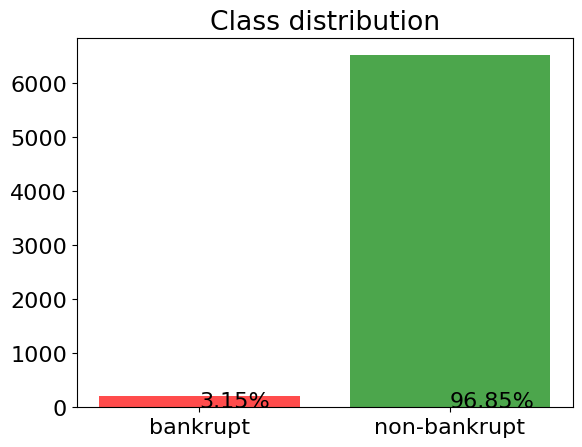

In [8]:
num_yes = len(df_final[df_final['bankrupt'] == 1])
num_no = len(df_final[df_final['bankrupt'] == 0])

plt.bar(['bankrupt', 'non-bankrupt'], [num_yes, num_no], color=['red', 'green'], alpha=0.7)
plt.title("Class distribution")
add_value_label(['bankrupt', 'non-bankrupt'], 
                [round(num_yes / (num_no + num_yes), 4), round(num_no / (num_no + num_yes), 4)])

### ROSE and SMOTE

ROSE and SMOTE are oversampling techniques, which generate more instances for lower numbered class. Unlike Random Oversampling, ROSE and SMOTE don't produce any duplicates of an instance, but a completely new datapoint in n-dimensional space, which is sufficiently close to other datapoints of minority class.

That's why it's important to use ROSE and SMOTE only for generating the training data. We don't want thr test set to contain any artificial instances. 

Below is the schema for this approach.

![train-test-split](train_test_split.png)

In [14]:
x_cols = list(df_final.columns)
x_cols.remove('bankrupt')
X = df_final[x_cols].to_numpy()
Y = df_final['bankrupt'].to_numpy().reshape(df_final.shape[0])

### 2.1. Split data

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
tr = np.unique(Y_train, return_counts=True)[1]
tst = np.unique(Y_test, return_counts=True)[1]
print(f"\tTrain set\n\nbankrupt instances: {tr[1]},\nnon-bankrupt instances: {tr[0]}\n")
print(f"\tTest set\n\nbankrupt instances: {tst[1]},\nnon-bankrupt instances: {tst[0]}")

	Train set

bankrupt instances: 141,
non-bankrupt instances: 4567

	Test set

bankrupt instances: 71,
non-bankrupt instances: 1948


## 2.2. Oversampling

### 2.2.1. ROSE

In [14]:
rose = RandomOverSampler(random_state=31)
X_rose, Y_rose = rose.fit_resample(X_train, Y_train)
print(Counter(Y_rose))

Counter({0: 4567, 1: 4567})


In [15]:
df_rose = pd.DataFrame(X_rose, columns=df_final.columns[:-1])
df_rose['bankrupt'] = Y_rose
df_rose.to_csv(os.path.join('data', '.local', 'processed_data', 'ROSE_data.csv'), index=None)

### 2.2.2. SMOTE

In [16]:
sm = SMOTE(random_state=42)
X_sm, Y_sm = sm.fit_resample(X_train, Y_train)
print(Counter(Y_sm))

Counter({0: 4567, 1: 4567})


In [17]:
df_smote = pd.DataFrame(X_sm, columns=df_final.columns[:-1])
df_smote['bankrupt'] = Y_sm
df_smote.to_csv(os.path.join('data', '.local', 'processed_data', 'SMOTE_data.csv'), index=None)

### 2.2.3. Save Train/Test data

In [18]:
df_train = pd.DataFrame(X_train, columns=df_final.columns[:-1])
df_train['bankrupt'] = Y_train
df_train.to_csv(os.path.join('data', '.local', 'processed_data', 'TRAIN_data.csv'), index=None)

In [19]:
df_test = pd.DataFrame(X_test, columns=df_final.columns[:-1])
df_test['bankrupt'] = Y_test
df_test.to_csv(os.path.join('data', '.local', 'processed_data', 'TEST_data.csv'), index=None)